#### 1. Import the Relevent Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from glob import glob
from torchsummary import summary
import os

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 2. Prepare the Dataset

In [179]:
class MyDataset(Dataset):
    
    def __init__(self, root):
        
        self.root = root
        self.images_paths = [glob(f'{root}/{folder}/*.jpg') for folder in os.listdir(f"{root}")] 

        import itertools
        self.images_paths = list(itertools.chain.from_iterable(self.images_paths))

        import random
        random.shuffle(self.images_paths)

        self.classes_names = {class_name:label for label, class_name in enumerate(os.listdir(f"{root}"))}
        self.labels = [self.classes_names[os.path.basename(os.path.dirname(path))] for path in self.images_paths]
        
        self.transform = transforms.Normalize(mean=[0.485,0.456, 0.406],std=[0.229, 0.224, 0.225])
    
    def __len__(self):
        return len(self.images_paths)   
        
    def __getitem__(self, index):
        image_path = self.images_paths[index]
        image = cv2.imread(image_path)[:,:,::-1]
        image = cv2.resize(image, (64,64))
        image = torch.tensor(image/255).permute(2,0,1)
        image = self.transform(image)
        label = self.labels[index]
        
        return image.float().to(device), torch.tensor([label]).float().to(device)
    
    

In [180]:
data =  MyDataset("dataset_rgb/train")

In [181]:
data.classes_names

{'River': 0,
 'HerbaceousVegetation': 1,
 'Residential': 2,
 'Highway': 3,
 'SeaLake': 4,
 'AnnualCrop': 5,
 'PermanentCrop': 6,
 'Forest': 7,
 'Industrial': 8,
 'Pasture': 9}

In [182]:
image, label = data[94]

Image Size: 64 x 64 x 3
Label: tensor([5.], device='cuda:0')
AnnualCrop


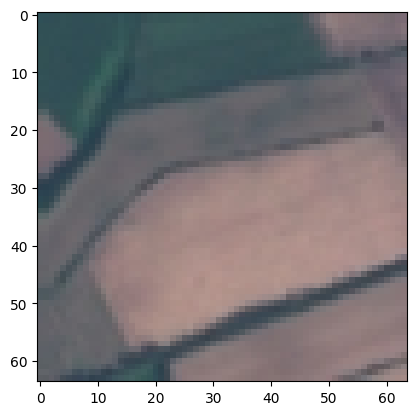

In [178]:
print(f"Image Size: {image.shape[2]} x {image.shape[1]} x {image.shape[0]}")
print(f"Label: {label}")
print([key  for key, value in data.classes_names.items() if value == label][0])
plt.imshow(image.permute(1,2,0).cpu().numpy())
plt.show()